# Data engineering

In [31]:
import os
import requests
import math
import scipy
import json

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")


# .env file should contain GHA_TOKEN variable which
# is access token for GitHub (generated per user)
from dotenv import load_dotenv
from datetime import datetime
from datetime import date
from scipy.stats import norm
from scipy.stats import shapiro
from scipy.stats import poisson
from scipy.stats import chisquare
from scipy.optimize import curve_fit
from collections import defaultdict, Counter

load_dotenv()

True

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
"""
GitHubActionsAPI is a class which wraps calling to GitHub APIs to get
data about runs
"""
class GitHubActionsAPI:
    def __init__(self, base_url: str, org: str, repo: str, access_token: str):
        self._base_url = base_url
        self._org = org
        self._repo = repo
        self._access_token = access_token
        
        self._workflow_runs_url = f"{self._base_url}/repos/{self._org}/{self._repo}/actions/runs"
        self._headers = {
            "Authorization": f"token {self._access_token}",
            "Accept": "application/vnd.github.v3+json",
        }

    def page_count(self, per_page: int = 100) -> int:
        params = {
            "per_page": per_page,
        }
        
        response = requests.get(self._workflow_runs_url, headers=self._headers, params=params)
        response.raise_for_status()
        workflow_runs = response.json()
        
        return math.ceil(workflow_runs["total_count"] / per_page)
        
        
    def load_workflows(self, page: int = 1, per_page: int = 100):
        params = {
            "per_page" : per_page,
            "page": page,
        }

        response = requests.get(self._workflow_runs_url, headers=self._headers, params=params)
        response.raise_for_status()
        workflow_runs = response.json()

        return workflow_runs["workflow_runs"]            
    
    def get_run_approvals(self, run_id):
        url = f"{self._workflow_runs_url}/{run_id}/approvals"
        response = requests.get(url, headers=self._headers)
        response.raise_for_status()
        return response.json()
    
    def get_run(self, run_id):
        url = f"{self._workflow_runs_url}/{run_id}"
        response = requests.get(url, headers=self._headers)
        response.raise_for_status()
        return response.json()
        

In [4]:
base_url = "https://api.github.com"
org = "lf-edge"
repo = "eve"
access_token = os.getenv("GHA_TOKEN")

gha = GitHubActionsAPI(base_url, org, repo, access_token)    

In [5]:
# Downloading and filtering only eden workflows, this might take time
# progress bar is for convinience :)
# NOTE: that if data is cached YOU SHOULD SKIP THIS STEP

from ipywidgets import IntProgress
from IPython.display import display

per_page = 100 # maximum for GitHub API
pages = gha.page_count(per_page)
eden_workflows = []

f = IntProgress(min=1, max=pages) # instantiate the bar
display(f) # display the bar

for i in range(1, pages+1):
    workflows = gha.load_workflows(i, per_page)
    for workflow in workflows:
        if '.github/workflows/eden.yml' in workflow['path']:
            eden_workflows.append(workflow)
    f.value += 1

print(f"In total we have {len(eden_workflows)} workflows")

IntProgress(value=1, max=195, min=1)

In total we have 4780 workflows


In [6]:
class GitHubWorkflowStat:
    def __init__(self, workflows):
        self._workflows = workflows
        
    def get_field_count(self, field: str):
        count = defaultdict(int)

        for wf in self._workflows:
            count[wf[field]] += 1
            
        return count
    
    def groupby(self, field: str):
        groups = defaultdict(list)
        
        for wf in self._workflows:
            groups[wf[field]].append(wf)
        
        return groups
    
    def pick(self, fields):
        data = []
        
        for wf in self._workflows:
            entry = []
            
            for field in fields:
                entry.append(wf[field])
            data.append(entry)
                
        return data
    
    def save(self, path: str):
        with open(path, 'w') as file:
            json.dump(self._workflows, file)

    def load(self, path: str):
        with open(path, 'r') as file:
            self._workflows = json.load(file)
    
def duration_time(workflow):
    return datetime.fromisoformat(workflow['updated_at']) - datetime.fromisoformat(workflow['run_started_at'])
    

In [7]:
# NOTE: if the data is cached SKIP THIS STEP

dur = []

for wf in eden_workflows:
    wf['duration'] = duration_time(wf).seconds / 3600

wf_stat = GitHubWorkflowStat(eden_workflows)

created_started_diff = []

for wf in eden_workflows:
    created_at_time = datetime.fromisoformat(wf['created_at'])
    started_at_time = datetime.fromisoformat(wf['run_started_at'])
    diff = (created_at_time - started_at_time).seconds
    created_started_diff.append(diff)
    
cs_diff = np.array(created_started_diff)
pd.DataFrame(cs_diff[cs_diff > 0] / 3600).describe()

,0
count,413.000000
mean,13.398984
std,6.447571
min,0.106944
25%,7.926944
50%,14.434444
75%,18.384444
max,23.984722


In [8]:
# for cached data
#wf_stat = GitHubWorkflowStat([])
#wf_stat.load("eden_workflows.json")

wf_stat.save("eden_workflows.json")

# Model selection

There are several approaches we can take to estimate upper-bound on how much we can spend:
1. Upper bound := How many minutes do we usually spend in month
2. Upper bound := How long does it ususally take to run a workflow X How many workflows there usually are in a month

Both approaches are vailable but have different granulatiry, thus could have very different estimation. Second estimate will be larger.

By ususally we assume 95% confidence interval

In [15]:
pd.DataFrame(wf_stat.get_field_count('conclusion').items(), columns=['run conclusion', '#'])

,run conclusion,#
0,skipped,3098
1,failure,1407
2,None,1
3,cancelled,184
4,success,90


### Note:

Most of the runs are skipped, only 90 out of 4784 runs are successful.
We will analyse not use skipped runs, since they are not adding any running time.

In [16]:
run_attempt_df = pd.DataFrame(wf_stat.get_field_count('run_attempt').items(), columns=['run attempt', '#'])
run_attempt_df

,run attempt,#
0,1,4367
1,2,238
2,3,87
3,4,48
4,5,21
5,6,8
6,10,2
7,15,1
8,7,5
9,18,1


In [17]:
fields = ['conclusion', 'run_attempt', 'duration', 'created_at']

df = pd.DataFrame(wf_stat.pick(fields), columns=fields)
df.created_at = pd.to_datetime(df.created_at)
df['year'] = df.created_at.dt.year
df['month'] = df.created_at.dt.month
# skipped workflows do not add to used time
actual_workflows = df[df.conclusion != 'skipped']

actual_workflows['year'] = actual_workflows.created_at.dt.year
actual_workflows['month'] = actual_workflows.created_at.dt.month

# Data sanity check

In [18]:
claimed_running_time = 72599

from_mask = df.created_at.dt.date >= date(year=2023,month=9,day=23)
to_mask = df.created_at.dt.date <= date(year=2023, month=10, day=23)

actual_running_time = df[from_mask & to_mask].duration.sum() * 60

print(f"From 23rd September till 23 October we actually ran {actual_running_time:.2f} minutes or {actual_running_time / claimed_running_time:.2f} of claimed running time")

From 23rd September till 23 October we actually ran 22736.43 minutes or 0.31 of claimed running time


In [19]:
# Last updated at 13.11.2023
claimed_running_time = 54591

from_mask = df.created_at.dt.date >= date(year=2023, month=10, day=23)
to_mask = df.created_at.dt.date <= date(year=2023, month=11, day=23)


actual_running_time = df[from_mask & to_mask].duration.sum() * 60
print(f"From 23rd October till 23 November we actually ran {actual_running_time:.2f} minutes or {actual_running_time / claimed_running_time:.2f} of claimed running time")

From 23rd October till 23 November we actually ran 26271.47 minutes or 0.48 of claimed running time


## How many hours do we usually spend in month in workflows?

In [20]:
def get_upper_lower_uniform_bound(data):
    mean = np.mean(data)
    std = np.std(data)

    confidence_level = 0.95
    alpha = 1 - confidence_level
    t_critical = scipy.stats.t.ppf(1 - alpha / 2, df=len(data)-1)

    lower_bound = mean - (std / np.sqrt(12 * len(data))) * t_critical
    upper_bound = mean + (std / np.sqrt(12 * len(data))) * t_critical

    return lower_bound, upper_bound

data = actual_workflows[actual_workflows.year == 2023].groupby('month').duration.sum().to_numpy()
_, upper2023 = get_upper_lower_uniform_bound(data)

data = actual_workflows[actual_workflows.year == 2022].groupby('month').duration.sum().to_numpy()
_, upper2022 = get_upper_lower_uniform_bound(data)

yearly_increase = (1 - upper2022 / upper2023)
hrs_per_year_running = 12 * upper2023 * (1 + yearly_increase)

runner_price = 0.008

print(f"Estimated cost for 2024: {hrs_per_year_running * 60 * runner_price:.2f}$")

Estimated cost for 2024: 3773.96$


## How long does it usually take to run a workflow?

<Axes: xlabel='duration', ylabel='Count'>

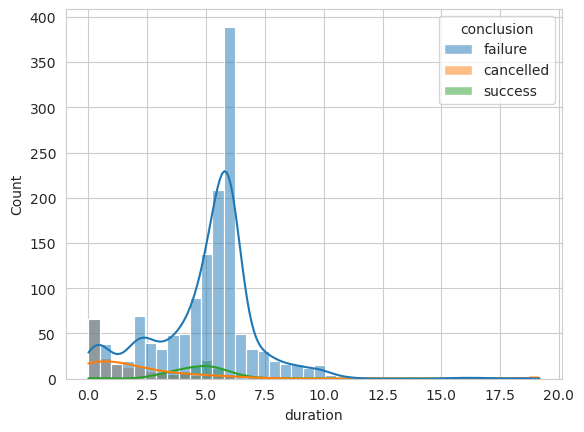

In [21]:
duration = actual_workflows.duration.to_numpy()

mu, std = norm.fit(duration)

sns.histplot(actual_workflows, x='duration', kde=True, hue='conclusion')

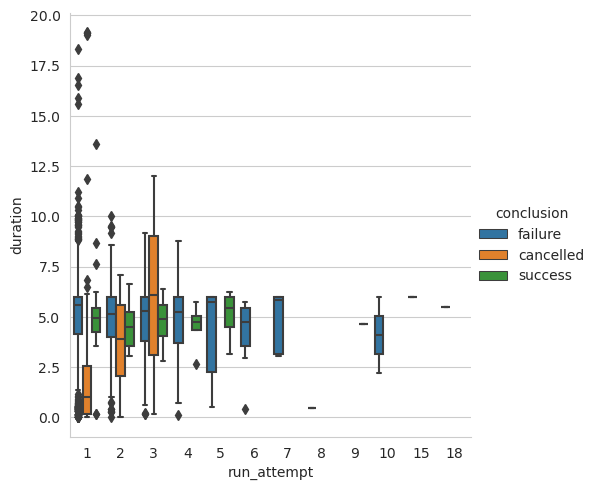

In [22]:
sns.catplot(data=actual_workflows, x="run_attempt", y="duration", hue="conclusion", kind="box")

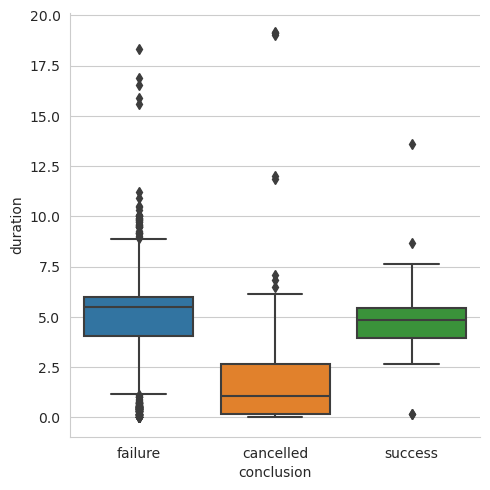

In [23]:
sns.catplot(data=actual_workflows, x="conclusion", y="duration", kind="box")

In [24]:
statistic, p_value = shapiro(duration)
print(f"Shapiro Test Statistic: {statistic}, P-value: {p_value}")

statistic, p_value = scipy.stats.normaltest(duration)
print(f"Pearson Test Statistic: {statistic}, P-value: {p_value}")

Shapiro Test Statistic: 0.9006378054618835, P-value: 1.0696562484078661e-31
Pearson Test Statistic: 210.55057137182342, P-value: 1.9033749345917067e-46


Graph and test tells us that distribution is *NOT* normal. From the looks of it it is Poisson distribution with very long tail.

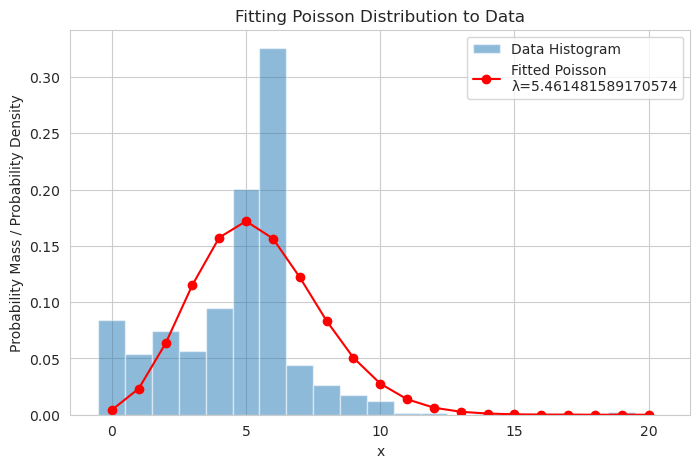

In [25]:
data = duration

def poisson_func(x, lambda_parameter):
    return poisson.pmf(x, lambda_parameter)

# Fit the Poisson distribution to the data
lambda_initial_guess = np.mean(data)
params, covariance = curve_fit(poisson_func,
                               np.arange(min(data), max(data) + 1),
                               np.histogram(data, bins=np.arange(min(data) - 0.5, max(data) + 1.5, 1),
                               density=True)[0],
                               p0=lambda_initial_guess)

# Extract the fitted lambda parameter
lambda_fitted = params[0]

# Generate the PMF of the fitted Poisson distribution
x_values = np.arange(min(data), max(data) + 1)
fitted_pmf = poisson.pmf(x_values, lambda_fitted)

# Plot the original data and the fitted distribution
plt.figure(figsize=(8, 5))
plt.hist(data, bins=np.arange(min(data) - 0.5, max(data) + 1.5, 1), density=True, alpha=0.5, label='Data Histogram')
plt.plot(x_values, fitted_pmf, 'ro-', label=f'Fitted Poisson\nλ={lambda_fitted}')
plt.title('Fitting Poisson Distribution to Data')
plt.xlabel('x')
plt.ylabel('Probability Mass / Probability Density')
plt.legend()
plt.show()

In [26]:
lambda_fitted = params[0]

# We use covariance under assumption that distribution is multimodal
# since it behaves differently depending on conclusion, to give
# better upper estimation
std_err_lambda = np.sqrt(np.diag(covariance))[0]

confidence_interval = (lambda_fitted - 1.96 * std_err_lambda, lambda_fitted + 1.96 * std_err_lambda)

print(f"Lambda: {lambda_fitted}")
print(f"95% Confidence Interval: {confidence_interval}")

Lambda: 5.461481589170574
95% Confidence Interval: (4.501608999244777, 6.421354179096371)


## Conclusion

In [27]:
time_takes_to_run_workflow = confidence_interval[1]

print(f"So it usually takes {time_takes_to_run_workflow:.2f} hrs to finish workflow")

So it usually takes 6.42 hrs to finish workflow


## How many workflows there usually are per month?

In [28]:
actual_workflows.created_at.dt.year.value_counts()

created_at
2023    1347
2022     335
Name: count, dtype: int64

<Axes: xlabel='month', ylabel='Count'>

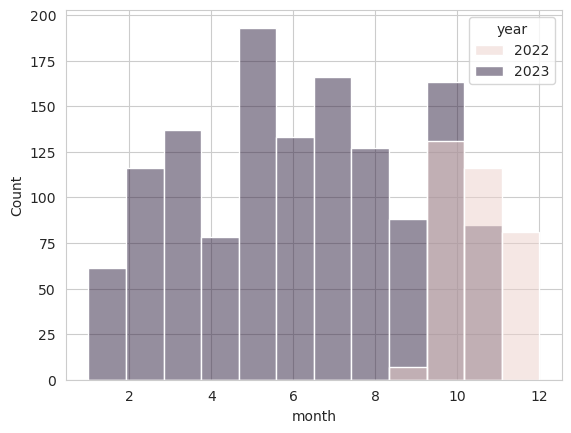

In [29]:
sns.histplot(actual_workflows, x='month', hue='year', bins=12)

In [47]:
data = np.array(actual_workflows[actual_workflows.year == 2023].month)

expected_values = np.full(12, 113)
observed_values, _ = np.histogram(data, bins=12)

chi2_stat, p_val = chisquare(observed_values, expected_values)

print(chi2_stat, p_val)

ValueError: For each axis slice, the sum of the observed frequencies must agree with the sum of the expected frequencies to a relative tolerance of 1e-08, but the percent differences are:
0.0066815144766146995

# Note

Chi square test fails, values are not uniformly distributed!!

[Text(0.5, 1.0, 'Month-to-Month diff for run numbers'),
 Text(0.5, 0, 'Month'),
 Text(0, 0.5, 'Diff to previous month')]

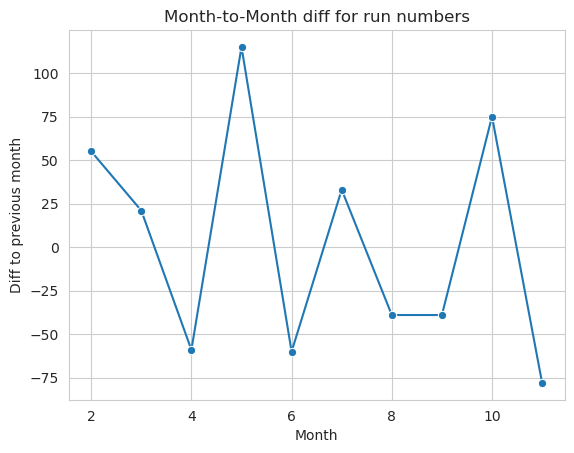

In [48]:
diff_data = actual_workflows[actual_workflows.year == 2023].groupby('month')['month'].count().diff()

sns.lineplot(diff_data, marker="o").set(
    title='Month-to-Month diff for run numbers',
    xlabel='Month',
    ylabel='Diff to previous month'
)

From all the information we have right now there are only 2 overlapping months and in 2023 we ran more workflows that in 2022. I guess GitHub has a sliding window to store history of workflow runs. We assume that this value is normally distributed

In [49]:
def avg_workflows(actual_workflows, year):
    wfCountMonthly = actual_workflows[actual_workflows.year == year].month.to_numpy()
    wfCountMonthly = list(Counter(wfCountMonthly).values())

    mean = np.mean(wfCountMonthly)
    std = np.std(wfCountMonthly)

    confidence_level = 0.95
    alpha = 1 - confidence_level
    t_critical = scipy.stats.t.ppf(1 - alpha / 2, df=len(wfCountMonthly)-1)

    lower_bound = mean - (std / np.sqrt(12 * len(wfCountMonthly))) * t_critical
    upper_bound = mean + (std / np.sqrt(12 * len(wfCountMonthly))) * t_critical

    
    return lower_bound, upper_bound

In [50]:
_, runs_per_month2022 = avg_workflows(actual_workflows, 2022)
print(f"So usually in 2022 we ran {runs_per_month2022:.2f} workflows per month")
print(80*'-')
_, runs_per_month2023 = avg_workflows(actual_workflows, 2023)
# since there are only 10 months out of 11 which are completed
runs_per_month2023 /= (10/11)
print(f"So usually in 2023 we ran {runs_per_month2023:.2f} workflows per month")

So usually in 2022 we ran 105.74 workflows per month
--------------------------------------------------------------------------------
So usually in 2023 we ran 143.15 workflows per month


## Conclusion

In [51]:
yearly_increase = (1 - runs_per_month2022 / runs_per_month2023)

hrs_per_year_running = 12 * runs_per_month2023 * (1 + yearly_increase) * time_takes_to_run_workflow

runner_price = 0.008

print(f"Estimated cost for 2024: {hrs_per_year_running * 60 * runner_price:.2f}$")

Estimated cost for 2024: 6677.95$


Original estimate was 7295 per year, so this is lower than expected.

# How many times are we re-approving?

## Data engineering

In [52]:
approvals = []


from ipywidgets import IntProgress
from IPython.display import display

f = IntProgress(min=0, max=len(eden_workflows)) # instantiate the bar
display(f) # display the bar


for wf in eden_workflows:
    approvals.append(gha.get_run_approvals(wf['id']))
    f.value += 1


IntProgress(value=0, max=4780)

In [53]:
for a in approvals:
    if len(a) > 0:
        print("Non-empty value")

# Other interesting visualisations:

## How many times we re-run workflows?

In [54]:
wide_df = df.pivot_table(values="duration", columns='conclusion', index='run_attempt', aggfunc='count')
wide_df

conclusion,cancelled,failure,skipped,success
run_attempt,,,,
1,178.0,1106.0,3050.0,32.0
2,4.0,162.0,44.0,28.0
3,2.0,67.0,3.0,15.0
4,NaN,38.0,1.0,9.0
5,NaN,16.0,NaN,5.0
6,NaN,8.0,NaN,NaN
7,NaN,5.0,NaN,NaN
8,NaN,1.0,NaN,NaN
9,NaN,NaN,NaN,1.0


[None]

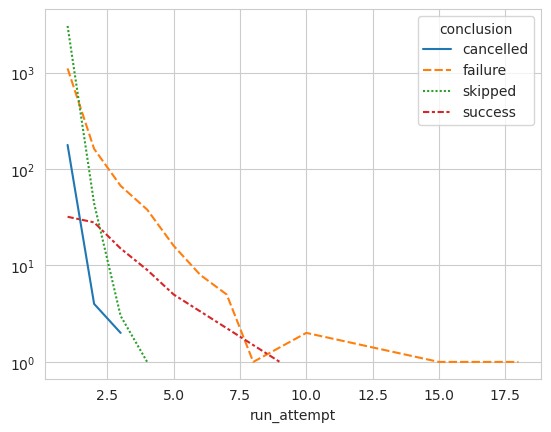

In [55]:
g_results=sns.lineplot(data=wide_df)
g_results.set(yscale='log')

# Does the arm outage affected eden build time?

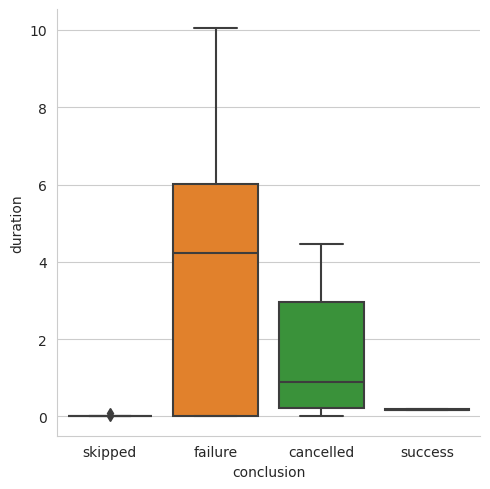

In [56]:
# 7.11.2023 arm server stuck. Let's plot what happened with time after 

from_mask = df.created_at.dt.date >= date(year=2023,month=11,day=8)
sns.catplot(data=df[from_mask], x="conclusion", y="duration", kind="box")

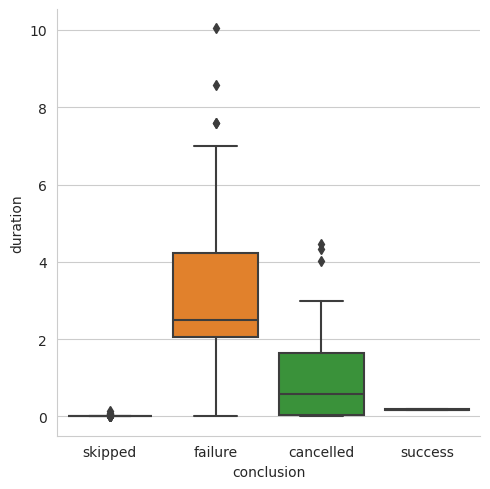

In [57]:
# and compare with what happened before

from_mask = df.created_at.dt.date >= date(year=2023,month=10,day=8)
to = df.created_at.dt.date <= date(year=2023,month=11,day=8)

sns.catplot(data=df[from_mask], x="conclusion", y="duration", kind="box")

We can see that time increased and started to be more broad